In [ ]:
import os
import time
import json

def experiment(request):
    experiment_path = os.path.join(SRC_FOLDER, 'experiment')
    results = {'names': [], 'chunks': [], 'start': [], 'end': [], 'runtimes': []}
    
    audios = os.listdir(os.path.join(experiment_path, 'audio'))
    print(audios)
    for audio_path in audios:
        if (audio_path == 'desktop.ini'):
            continue
        filename = audio_path.rsplit('.', 1)[0]
        print(filename)
        audio_path = os.path.join(experiment_path, 'audio', audio_path)
        print(audio_path)
        title, artist = recognise_audio(audio_path, filename)
        transcript = get_synced_lyrics(title, artist, experiment_path, filename)

        audio = Audio(music=True, artist=artist, title=title, filename=filename, transcript=transcript, 
                coverart_colour="rgb(0, 0, 0)", _ground_truth="null")
        audio.save(True)

        transcript = pylrc.parse(transcript)
        id = 1
        for i in range(len(transcript) - 1):      
            line = transcript[i]
            print(f"Chunk {id}: {line.text}")
            chunk = Chunk.objects.filter(index=id, audio__slug=audio.slug)
            if chunk.exists():
                # print("Updating existing Chunk...")
                chunk.update(text=line.text, audio_id=audio.id, start_time=line.time, end_time=transcript[i+1].time, 
                    _image_ids=chunk[0]._image_ids, _selected_ids=chunk[0]._selected_ids)
                chunk = chunk[0]
            else:
                chunk = Chunk(index=id, text=line.text, audio_id=audio.id, start_time=line.time, 
                    end_time=transcript[i+1].time, _image_ids="[]", _selected_ids="[]")
                chunk.save()
            id += 1
        
        chunks = list(Chunk.objects.filter(audio__slug=audio.slug))
        video_path = os.path.join(experiment_path, 'video', f"{audio.filename}.mp4")
        
        # ----- VIDEO GENERATION RUNTIME EXPERIMENT ------
        results['start'].append(time.time())
        build_video(chunks, clip, audio_path, video_path)
        results['end'].append(time.time())
        # ------------ END OF EXPERIMENT -----------------
        
        results['names'].append(str(audio))
        results['chunks'].append(len(chunks))
        results['runtimes'].append(get_transcript_length(transcript))

        with open(os.path.join(experiment_path, 'results', "experiment.json"), "a") as file:
            json.dump(results, file)

    print(results['chunks'])
    print(results['start'])

    return HttpResponse("Experiments Done")

In [143]:
import json
import numpy as np

with open("videography_experiment_result.json", "r") as result_json:
    result = json.load(result_json)

result['names'] = np.array(result['names'])
result['chunks'] = np.array(result['chunks'])
result['start'] = np.array(result['start'])
result['end'] = np.array(result['end'])
result['runtimes'] = np.array(result['runtimes'])

generation_times = result['end'] - result['start']

print(f"Number of audio sources: {len(result['chunks'])}")
print(f"Total number of chunks: {result['chunks'].sum()}")
print(f"Mean number of chunks per source: {result['chunks'].mean():.4f} | std={result['chunks'].std():.2f}")
print(f"Mean audio runtime of sources: {result['runtimes'].mean() / 60:.4f} mins | std={result['runtimes'].std() / 60:.2f} mins")
print(f"Mean video generation time: {generation_times.mean() / 60:.4f} mins | std={generation_times.std() / 60:.2f} mins")

print()
print(result['chunks'])
print(generation_times / 60)

# NORMALISED TIMES BY NUMBER OF CHUNKS
# normalised_times = (generation_times*generation_times) / (result['chunks']*result['runtimes'])
normalised_times = generation_times / result['chunks']
print(normalised_times)

print(f"\nMean time taken per chunk: {normalised_times.mean():.4f}s | std={normalised_times.std():.2f}s")

print(f"\nMean number of chunks for audio sources x mean time per chunk: {normalised_times.mean()*result['chunks'].mean() / 60} mins")

weighted_chunks = result['chunks']*result['runtimes']
print(f"\nMean number of chunks weighted by audio runtime: {weighted_chunks.mean() / result['runtimes'].mean():.4f}")

normalised_weighted_times = generation_times / weighted_chunks
print(f"\n\nMean time taken per weighted chunk: {normalised_weighted_times.mean():.4f}s")
print(f"\nMean number of chunks x Mean video runtime x mean time per weighted chunk: {result['chunks']*result['runtimes'].mean()*normalised_weighted_times.mean() / 60} mins")

Number of audio sources: 30
Total number of chunks: 1239
Mean number of chunks per source: 41.3000 | std=18.25
Mean audio runtime of sources: 3.9344 mins | std=0.86 mins
Mean video generation time: 4.6449 mins | std=1.59 mins

[61 22 42 62 43 81 80 62 34 36 53 69 74 51 36 28 21 37 38 32 30 26 26 43
 26 19 18 24 26 39]
[4.90838204 4.27701103 2.5060062  3.02796091 6.43213103 7.16419371
 7.59311121 6.15829962 3.09125995 4.72057741 6.97297697 5.13386566
 7.19874259 4.27077902 3.99836903 3.78016148 2.80808772 2.74153214
 3.58361446 5.33589163 6.09521803 2.55631623 5.54571935 4.0659254
 3.81518177 2.70919744 3.91520702 4.07474817 3.25136099 7.61641578]
[ 4.82791676 11.66457554  3.58000886  2.93028475  8.97506656  5.30681016
  5.6948334   5.95964479  5.45516462  7.86762902  7.8939362   4.46423101
  5.83681832  5.02444591  6.66394839  8.10034604  8.02310778  4.44572779
  5.65833862 10.00479681 12.19043605  5.8991913  12.79781389  5.67338427
  8.80426562  8.55536034 13.05069005 10.18687042  7.5

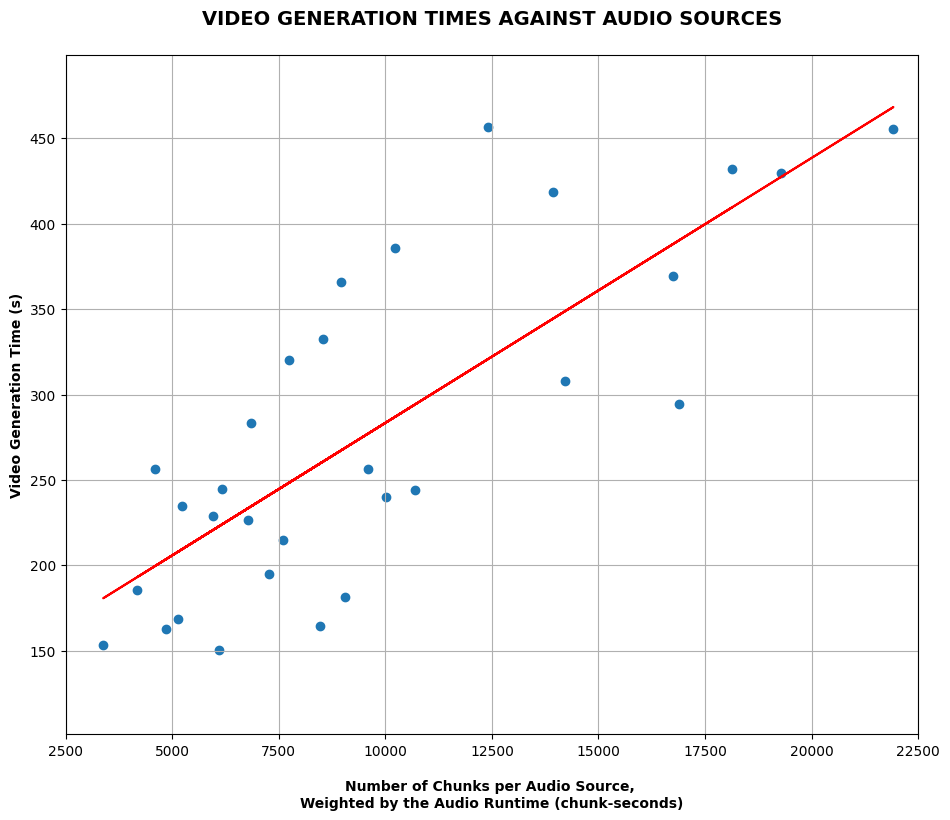

In [144]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(11, 9), dpi=100)
ax = fig.add_subplot(1, 1, 1)

theta = np.polyfit(weighted_chunks, generation_times, 1)
bf_line = theta[0]*weighted_chunks + theta[1]
ax.plot(weighted_chunks, bf_line, 'r')
ax.scatter(weighted_chunks, generation_times)

ax.set_xlim(left=2500, right=22500)
ax.set_ylim(top=499, bottom=101)

ax.set_title("VIDEO GENERATION TIMES AGAINST AUDIO SOURCES\n", size=14, fontweight="bold")
ax.set_xlabel("\nNumber of Chunks per Audio Source, \nWeighted by the Audio Runtime (chunk-seconds)", fontweight="bold")
ax.set_ylabel("Video Generation Time (s)", fontweight="bold")
ax.grid(True)